## Selección de modelos para clasificación de imágenes de textura  
Cristopher Lincoleo  
28-08-2023

El objetivo principal de este estudio es llevar a cabo una comparación exhaustiva de diversos clasificadores supervisados utilizando un conjunto de datos que se centra en texturas. La fuente de las imágenes proviene del proyecto [T1k+: Database for Benchmarking Color Texture Classification and Retrieval Methods](https://www.mdpi.com/1424-8220/21/3/1010). Este conjunto de datos se compone de un total de 10 clases distintas de texturas, y en cada clase, se encuentran 50 imágenes, lo que suma un total de 500 imágenes en el conjunto de datos.  

Para caracterizar estas texturas, se extraen seis descriptores de textura clave: contraste, energía, ASM (Angular Second Moment), homogeneidad, correlación y disimilaridad, de cada imagen. Esta extracción se realiza tanto para los canales de color RGB como para la representación en escala de grises. Esto ha dado como resultado un conjunto de datos con un total de 24 características para cada imagen.  

Para la reducción de la dimensionalidad, se aplica un LDA (_linear discriminant analysis_). El LDA permite identificar las componentes de descriptores que maximizan la distancia entre las clases de texturas.

En cuanto al proceso de _feature selection_, inicialmente, se utiliza un árbol de decisión para evaluar la importancia de cada característica en el proceso de clasificación. Esto permite identificar las características más relevantes. Posteriormente, se ejecuta un conjunto de 11 modelos de clasificación diferentes y optimizamos el clasificador que logró el mayor F1-score promedio en base a 30 repeticiones de validación cruzada (Repeated K-Fold)

Finalmente, se analizan las curvas de aprendizaje de los modelos modelos mejor evaluados y se seleccionó el modelo ajustado más adecuado (accuracy del 97%)

### 1. Librerias necesarias

In [1]:
#Tratamiento de imágenes
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread_collection
from skimage import color

#Tratamiento de datos
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

#direcciones
import glob
import zipfile
import tempfile
import os 
from pathlib import Path #para manejar direcciones

#Matemáticas
from math import radians
import pandas as pd
import numpy as np

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import call

#Modelos de discriminación
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Modelos de clasificación
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#Métricas y validación
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold, RepeatedKFold, learning_curve, ShuffleSplit
from collections import Counter
from sklearn.metrics import make_scorer, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay

#Selección de características
from sklearn.feature_selection import SequentialFeatureSelector

#Presentación de resultados
pd.set_option('display.max_columns', 25)

### 2. Carga de datos y generación de dataframe de descriptores
#### 2.1 Función para carga y procesamiento de imágenes

La siguiente función realiza:

Posteriormente procesa las imágenes: 
1. Abre un directorio temporal para extraer el contenido del archivo Zip que contiene las imágenes
2. Descomprime el archivo Zip
3. Realiza una búsqueda recursiva de archivos *.jpg*
4. Crea una colección de imágenes 
5. Extrae descriptores de la imagen de un canal elegido con el algoritmo Graycomatrix
6. Genera un dataframe de descriptores de cada imagen del canal elegido y un dataframe con sus clases
7. Retorna ambos dataframes

In [2]:
def obtener_features (color_type, zip_file_path, level):
    features = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity', 'ASM'] # Características buscadas

    """ 
    La función recibe:
    color_type: canal de color a utilizar, puede ser 'gray', 'blue', 'green' o 'red'
    zip_file_path: ruta del archivo zip que contiene las imágenes
    level: número de niveles al cual reducir el conjunto de pixeles de la imagen 
    
    Posteriormente procesa las imágenes:
    1. Abre un directorio temporal para extraer el contenido del archivo Zip que contiene las imágenes
    2. Descomprime el archivo Zip
    3. Realiza una búsqueda recursiva de archivos *.jpg*
    4. Crea una colección de imágenes 
    5. Extrae descriptores de la imagen de un canal elegido con el algoritmo Graycomatrix
    6. Genera un dataframe de descriptores de cada imagen del canal elegido y un dataframe con sus clases
    7. Retorna ambos dataframes
    """
    
    F = [] # Lista para almacenar los descriptores de cada imagen
    color_type = color_type # Canal de color a utilizar
    level = level

    # Ruta al archivo ZIP
    zip_file_path = zip_file_path

    # Crea un directorio temporal para extraer el contenido del ZIP
    with tempfile.TemporaryDirectory() as temp_dir:
        # Descomprime el archivo ZIP en el directorio temporal
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)

        # Patrón para buscar archivos de imágenes
        image_pattern = os.path.join(temp_dir, '**', '*.jpg')

        # Obtén rutas de todas las imágenes encontradas usando glob
        image_paths = glob.glob(image_pattern, recursive=True)

        # Crea una colección de imágenes usando imread_collection
        image_collection = imread_collection(image_paths)

        # Procesamiento y extracción de características para cada imagen
        for image_path, img in zip(image_paths, image_collection):
            if color_type == 'gray':
            # convertimos la imagen a escala de grises
                color_chanel =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            elif color_type == 'blue':
                color_chanel = img[:, :, 0]
            elif color_type == 'green':
                    color_chanel = img[:,:,1]
            elif color_type == 'red':
                color_chanel = img[:,:,2]   
            
            #transforma la imagen a una columna
            m_color_chanel = color_chanel.reshape(-1,1)
            
            # Escalamos los datos en una matriz con menos valores
            new_scale = (0,level)
            new_color = MinMaxScaler(new_scale).fit_transform(m_color_chanel).astype(int)

            #volver a transformar el vector en una imagen
            new_color = new_color.reshape(color_chanel.shape)

            # --> algoritmo graycomatrix P01
            # numero de niveles de la imagenq
            l = np.max(new_color)+1

            # extracción de caracteristicas a traves de graycomatrix
            P_1_0 = graycomatrix(new_color, distances=[1], angles=[radians(90)], levels=l, symmetric=False, normed=True)
            texture_features = [graycoprops(P_1_0, ft).ravel()[0] for ft in features]
            #F.append((filename,) + tuple(texture_features))
            F.append(texture_features)
        
        
        col_names = [f"{color_type}_{feature}" for feature in features]
        # Crear el DataFrame
        texture_df = pd.DataFrame(F, columns=col_names)

        # Convertir las rutas en objetos Path
        image_paths = [Path(path) for path in image_paths]
        # Obtener una lista de clases de textura
        texture_classes = pd.DataFrame({'clase_textura': [path.parent.name for path in image_paths]})



        # Agregar directamente la columna 'ruta_part' utilizando pathlib
        #texture_df['clase_textura'] = [path.parent.name for path in image_paths]   

    # >> FIN ciclo para cada imagen de textura
    return texture_df, texture_classes

#### 2.2 Ejecución de la función y generación de dataset con los descriptores para 4 canales
* A continuación, se pasan los parámetros iniciales para la función de obtenención de características.  
* La función genera dos dataframes, uno de texturas para 1 canales y otro con las clases.  
* Para no repetir la función 4 veces, recorremos una lista con los canales y concatemos con un df de clases.

In [3]:
color_types = ['gray', 'blue', 'green', 'red']
zip_file_path = 'BD.zip'
level = 15

# Aplicar la función obtener_features a cada color_type y almacenar los resultados en una lista
dfs = [obtener_features(color_type, zip_file_path, level) for color_type in color_types]

# Extraer las clases de textura de uno de los DataFrames
classes_column = dfs[0][1]['clase_textura']

# Reemplazar los nombres de las clases por números
classes_column = classes_column.replace({
                'textura_01': 1,
                'textura_02': 2,
                'textura_03': 3,
                'textura_04': 4,
                'textura_05': 5,
                'textura_06': 6,
                'textura_07': 7,
                'textura_08': 8,
                'textura_09': 9,
                'textura_10': 10
                }).astype('category')

# Concatenar solo las características de los DataFrames
dfs_features = [df[0] for df in dfs]
final_df = pd.concat(dfs_features, axis=1)

# Agregar la columna de clases al DataFrame final
final_df['clase_textura'] = classes_column
final_df

,gray_contrast,gray_energy,gray_homogeneity,gray_correlation,gray_dissimilarity,gray_ASM,blue_contrast,blue_energy,blue_homogeneity,blue_correlation,blue_dissimilarity,blue_ASM,green_contrast,green_energy,green_homogeneity,green_correlation,green_dissimilarity,green_ASM,red_contrast,red_energy,red_homogeneity,red_correlation,red_dissimilarity,red_ASM,clase_textura
0,1.076932,0.168886,0.689020,0.958068,0.695888,0.028522,0.941880,0.181729,0.706354,0.956000,0.645333,0.033025,1.083213,0.167422,0.688203,0.958979,0.698313,0.028030,1.094361,0.166644,0.686113,0.957505,0.703582,0.027770,1
1,1.295759,0.156863,0.662476,0.955158,0.774731,0.024606,1.148594,0.169405,0.680013,0.953054,0.722313,0.028698,1.310538,0.155456,0.661033,0.955769,0.779550,0.024167,1.290153,0.156631,0.663711,0.954178,0.771823,0.024533,1
2,1.243197,0.162553,0.674452,0.954287,0.745783,0.026423,1.159261,0.169155,0.683698,0.952429,0.717237,0.028613,1.265510,0.158443,0.671654,0.955215,0.753960,0.025104,1.218426,0.161273,0.675456,0.953513,0.740289,0.026009,1
3,1.327968,0.156967,0.657141,0.946615,0.789205,0.024639,1.233398,0.163461,0.667481,0.945736,0.757092,0.026719,1.337799,0.156108,0.656857,0.947646,0.791325,0.024370,1.312016,0.157360,0.658128,0.944857,0.785076,0.024762,1
4,1.369992,0.156499,0.655151,0.944114,0.798618,0.024492,1.242201,0.167664,0.668790,0.941959,0.756161,0.028111,1.357205,0.157851,0.657305,0.945172,0.793189,0.024917,1.408916,0.155024,0.651835,0.942733,0.810297,0.024032,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.484161,0.226692,0.803261,0.962626,0.408337,0.051389,0.577735,0.230451,0.781208,0.942123,0.460337,0.053108,0.467695,0.226892,0.807049,0.964745,0.399325,0.051480,0.471020,0.230449,0.807352,0.963177,0.399341,0.053107,10
496,0.499422,0.225072,0.798235,0.960284,0.419357,0.050658,0.644900,0.219248,0.765358,0.943312,0.497912,0.048070,0.479614,0.228005,0.804397,0.962655,0.405783,0.051986,0.502827,0.224977,0.797725,0.960533,0.420771,0.050615,10
497,0.463149,0.234118,0.804265,0.956608,0.403229,0.054811,0.523084,0.240129,0.787226,0.938861,0.441510,0.057662,0.456193,0.232115,0.805565,0.958913,0.399904,0.053877,0.471036,0.231506,0.801035,0.957071,0.409928,0.053595,10
498,0.429285,0.238692,0.818549,0.963133,0.373831,0.056974,0.504546,0.239990,0.798310,0.949183,0.419888,0.057595,0.412289,0.239845,0.823287,0.964760,0.363133,0.057526,0.424562,0.241816,0.819965,0.962863,0.370683,0.058475,10


### 3. Análisis discriminante

Se realiza la separación de clases mediante un Análisis Discrimiante Lineal (LDA), que corresponde a una generalización del discriminante de Fisher.

In [4]:
# Separación en variable dependiente e independiente
X = final_df.drop('clase_textura', axis =1)
y = final_df['clase_textura']

In [5]:
# Modelo y ajuste
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

Se observa la proporción de la varianza explicada por cada componente, se generan 9 componentes

In [6]:
# Obtener la proporción de varianza explicada por cada componente
explained_variance_ratio = lda.explained_variance_ratio_

# Imprimir la proporción de varianza explicada por cada componente
for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Componente {i}: {ratio:.4f}")

Componente 1: 0.3345
Componente 2: 0.2497
Componente 3: 0.1334
Componente 4: 0.1058
Componente 5: 0.0758
Componente 6: 0.0473
Componente 7: 0.0337
Componente 8: 0.0108
Componente 9: 0.0090


Ploteamos la separacion con los 2 primeros discriminantes en el nuevo espacio creado

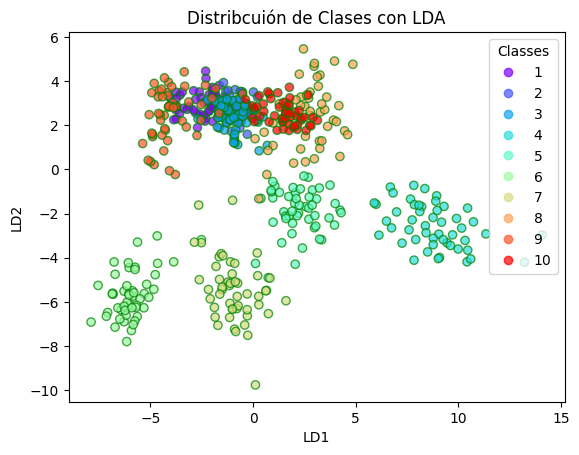

In [7]:
# Etiquetas de los componentes
plt.xlabel('LD1')
plt.ylabel('LD2')

# Ploteo de los dos primeros componentes
scatter = plt.scatter(
    X_lda[:, 0],
    X_lda[:, 1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='g'
)

# Leyenda para las 10 clases
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Distribcuión de Clases con LDA')

plt.show()

### 4. Selección de variables  
#### 4.1 Árbol de decisción
En primer lugar se ajustará un modelo de árbol de decisión para determinar la importancia de las variables para el modelo de clasificación.  
Resulta conveniente por su simpleza y porque el algoritmo basa la decisión de abrir un nodo de acuerdo al criterio de ganancia de información.

In [8]:
#Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.30, random_state=42)

#Analizaremos la importancia de características con el modelo de árbol de decisión
modelo = DecisionTreeClassifier(criterion='entropy',
                                min_samples_leaf=8,
                                max_depth=5)


#fase de entrenamiento
modelo.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=8)

#### 4.2 Gráfica del modelo de decisiones
Un vistazo de cómo trabaja el árbol de decisión, vemos que la feature que inicia el árbol es la feature_1.  
Se puede observar la importancia de cada característica dentro del modelo de árbol de decisión, esto nos da una idea cuanto contribuye una característica a la capacidad del modelo para realizar predicciones precisas.  
Las features 1, 2 y 0 son las que más aportan. La 6 prácticamente no tiene importancia.

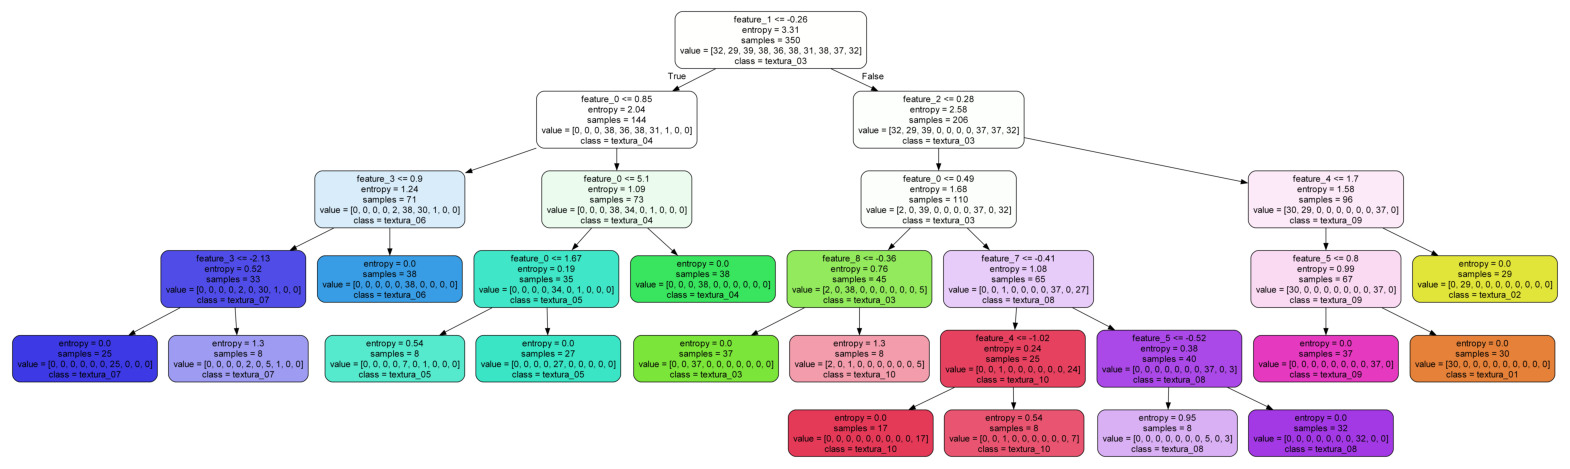

In [9]:
# Lista de nombres de las características
feat = [f"feature_{i}" for i in range(X_lda.shape[1])]

# Exporta el modelo a un formato de árbol
export_graphviz(modelo, out_file='tree.dot',
                feature_names = feat,
                class_names = ['textura_01', 'textura_02', 'textura_03', 'textura_04', 'textura_05', 'textura_06', 'textura_07', 'textura_08', 'textura_09', 'textura_10'],
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Covierte el modelo (tree.dot) en un grafico
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

plt.figure(figsize = (20, 15))
plt.imshow(plt.imread('tree.png'))
plt.axis('off')
plt.show()


#### 4.3 Importancia de las características
El diagrama anterior se relaciona con la importancia de las características pero es mejor obtenerla directamente desde el modelo.  
Para la selección se usó el método SBS, de manera manual, al tratarse de pocas características no demanda mucho trabajo (las 24 originales fueron combinadas en vectores por medio de LDA).  
Se seleccionaron las features de acuerdo a un umbral de importancia de 0.05, resultaron 6 características

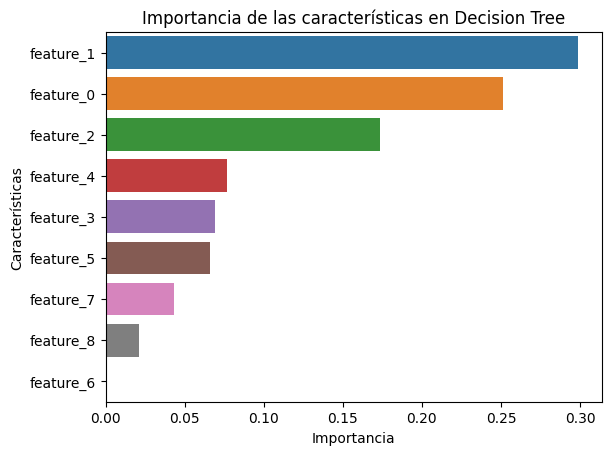

In [10]:
# Obtener la importancia de las caracteristicas en el modelo.
feature_importance = modelo.feature_importances_

# Crear un DataFrame para almacenar las características y sus importancias
importance_df = pd.DataFrame({'Feature': feat, 'Importance': feature_importance})

# Ordenar el DataFrame por importancia en orden descendente
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Crear un gráfico de barras de la importancia de las características
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las características en Decision Tree')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

In [11]:
importance_df

,Feature,Importance
1,feature_1,0.298609
0,feature_0,0.251290
2,feature_2,0.173201
4,feature_4,0.077069
3,feature_3,0.069107
5,feature_5,0.066075
7,feature_7,0.043534
8,feature_8,0.021113
6,feature_6,0.000000


In [12]:
# Selección de índices de las características de mayor importancia
selec = importance_df[importance_df['Importance'] > 0.05] # Selección de índices con importancia > 0.05

X_train_selec = X_train[:, selec.index]
X_test_selec = X_test[:, selec.index]

### 5. Modelamiento
#### 5.1 Modelos con validación cruzada

En principio se compararon 3 clasificadores de acuerdo a su F1-score promedio (se obtuvo el promedio y desviación estándar mediante kfold cross validation de 3 splits y 10 repeticiones por split). Es tarea sencilla comparar otros modelos así que se incorporaron otros clasificadores al análsis
* **Decision Tree**
* **Naive Bayes**
* **KNN**
* SVC
* AdaBoost
* Random Forest
* Extra Tree
* GradientBoosting
* MLP
* Logistic Regression
* LDA


In [13]:
# Definir el scorer de F1 para que funcione con cross_val_score
f1_scorer = make_scorer(f1_score, average='weighted')

In [14]:
random_state = 2023
# Configurar la semilla aleatoria para reproducibilidad
np.random.seed(random_state)

In [15]:
# Crear el objeto RepeatedKFold para realizar la validación cruzada repetida, se divide en 3 partes y se repite 10 veces
rkf = RepeatedKFold(n_splits=3, n_repeats=10, random_state=random_state)

#### 5.2 Función para comparar clasificadores
Se crea una lista con los clasificadores, la función recopila y devuelve los resultados en torno al F1-score.  
Se utiliza una segunda función se para plotear los resultados  
El mejor clasificador escogido es Extra_Tree con F1 promedio = 0.9631 y DesvEst = 0.016.

In [16]:
#Creación de lista de clasificadores
classifiers = []
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianNB())
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier()))
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(MLPClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

In [17]:
def comparar_clasificadores(models, X, y, cv):
    cv_results = []
    for classifier in classifiers :
        cv_results.append(cross_val_score(classifier, X= X, y = y, scoring = f1_scorer, cv = rkf, n_jobs=-2))

    cv_means = []
    cv_std = []
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","GaussianNB","AdaBoost",
    "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
    return cv_res

In [18]:
def plotear_resultados(resultado, ancho, alto):
    
    plt.figure(figsize=(ancho,alto))
    g = sns.barplot(x="CrossValMeans",y="Algorithm",data = resultado, palette="Set3",orient = "h",**{'xerr':resultado['CrossValerrors']})
    g.set_xlabel("Mean F1 Score")
    g = g.set_title("Cross validation scores")
    
    # Agregar los valores de cada barra
    ax = g.axes
    for index, value in enumerate(resultado['CrossValMeans']):
        ax.annotate(f'{value:.4f}', xy=(value, index), color='black', va='center', ha='right')

    plt.show()

In [19]:
resultado = comparar_clasificadores(classifiers, X_train_selec, y_train, rkf).sort_values(by='CrossValMeans', ascending=False)
resultado

,CrossValMeans,CrossValerrors,Algorithm
5,0.963189,0.016867,ExtraTrees
2,0.961031,0.014175,GaussianNB
9,0.959012,0.012626,LogisticRegression
8,0.954939,0.017121,KNeighboors
0,0.953091,0.020699,SVC
7,0.950805,0.013933,MultipleLayerPerceptron
4,0.945794,0.014724,RandomForest
10,0.944618,0.019744,LinearDiscriminantAnalysis
1,0.909103,0.025091,DecisionTree
6,0.908496,0.026364,GradientBoosting


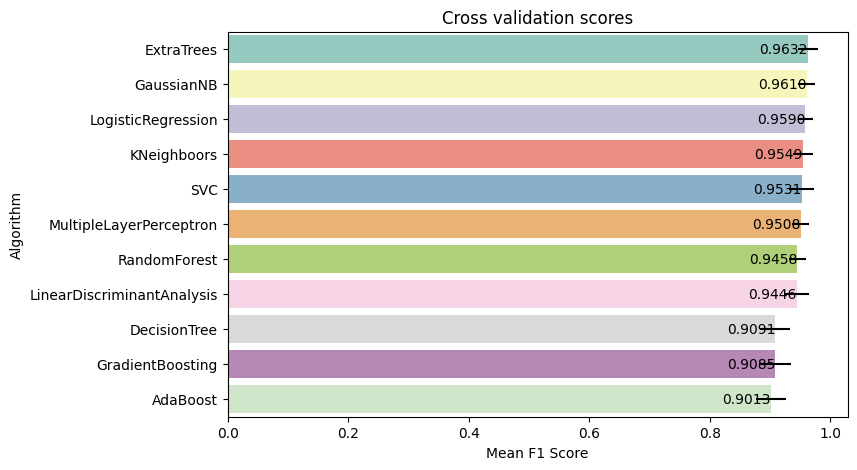

In [20]:
plotear_resultados(resultado, 8, 5)

#### 5.3 Ajuste del modelo para realizar predicciones
Con el modelo ExtraTreesCalassifier se obtuvo un accuracy del 97% en las predicciones del conjunto de test

In [21]:
# Ajustar el modelo ExtraTreesClassifier
extraTree_model = ExtraTreesClassifier()
extraTree_model.fit(X_train_selec, y_train)

ExtraTreesClassifier()

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        21
           3       0.92      1.00      0.96        11
           4       1.00      1.00      1.00        12
           5       1.00      0.86      0.92        14
           6       1.00      1.00      1.00        12
           7       0.90      1.00      0.95        19
           8       1.00      0.83      0.91        12
           9       1.00      0.92      0.96        13
          10       0.90      1.00      0.95        18

    accuracy                           0.97       150
   macro avg       0.97      0.96      0.96       150
weighted avg       0.97      0.97      0.97       150



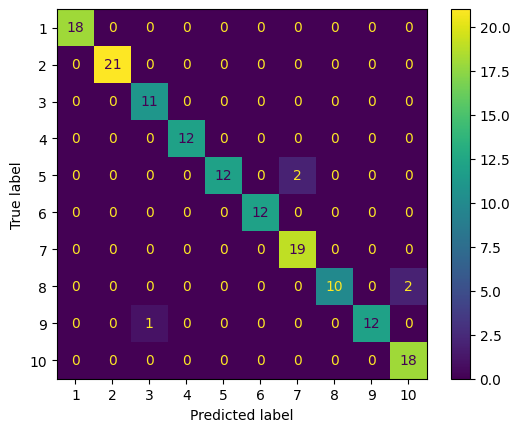

In [22]:
#predecir
y_estimado = extraTree_model.predict(X_test_selec)

#mostrar los resultados de la matriz de confusión.
cm = confusion_matrix(y_test, y_estimado)
print(classification_report(y_test, y_estimado))
disp = ConfusionMatrixDisplay(cm, display_labels=('1','2','3', '4','5','6','7','8','9','10'))

disp.plot()
plt.show()

### 5.4 Optimización de hiperparámetros del modelo seleccionado

***Tarda entre 2 y 3 minutos.***  
Primero ss realiza una búsqueda exhaustiva de parámetros (1350 fits) según la grilla a continuación.
De este modo se puede probar con diferente número de características. Además acotamos la profundidad máxima del árbol.
Los parámetros encontrados son:

bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 5, 'n_estimators': 100  
F1 score = 0.9655  

Se observa que no hay un aumento considerable del score. Por lo que se prueba un tercer modelo con 3 features. El resultado es el siguiente:  
Fitting 30 folds for each of 9 candidates, totalling 270 fits
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 3, 'n_estimators': 500}
F1 score = 0.9631  

Bastante aceptable, solo con 3 características y 270 ajustes.

In [23]:
#Optimización del modelo seleccionado
extraTree_model = ExtraTreesClassifier()
param_grid = {
    'n_estimators' : [100,300,500], #número de árboles
    'max_depth' : [2,5,8],
    #'min_samples_split': [2, 3, 10],
    #'min_samples_leaf': [1, 3, 10],
    'max_features' : [2,3,4,5,6],
    'bootstrap': [True],
    "criterion": ['entropy']
}

opt_ex_tree_gs = GridSearchCV(extraTree_model, param_grid = param_grid, cv= rkf, scoring=f1_scorer, n_jobs = -2, verbose = 2)
opt_ex_tree_gs.fit(X_train_selec,y_train)

# Mejores parámetros
best_opt_ex_tree=opt_ex_tree_gs.best_params_
print(best_opt_ex_tree)
# Mejor score
best_score = opt_ex_tree_gs.best_score_
print(best_score)

Fitting 30 folds for each of 45 candidates, totalling 1350 fits
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 5, 'n_estimators': 300}
0.9642577161610549


In [24]:
#Segunda optimización del modelo seleccionado, pero con 3 parámetros
#Optimización del modelo seleccionado
extraTree_model = ExtraTreesClassifier()
param_grid = {
    'n_estimators' : [100,300,500], #número de árboles
    'max_depth' : [2,5,8],
    #'min_samples_split': [2, 3, 10],
    #'min_samples_leaf': [1, 3, 10],
    'max_features' : [3],
    'bootstrap': [True],
    "criterion": ['entropy']
}

opt_ex_tree_gs3f = GridSearchCV(extraTree_model, param_grid = param_grid, cv= rkf, scoring=f1_scorer, n_jobs = -2, verbose = 2)
opt_ex_tree_gs3f.fit(X_train_selec,y_train)

# Mejores parámetros
best_opt_ex_tree_2=opt_ex_tree_gs3f.best_params_
print(best_opt_ex_tree_2)
# Mejor score
best_score_2 = opt_ex_tree_gs3f.best_score_
print(best_score_2)

Fitting 30 folds for each of 9 candidates, totalling 270 fits


{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 3, 'n_estimators': 500}
0.9631830669738434


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.95      1.00      0.98        21
           3       0.92      1.00      0.96        11
           4       1.00      1.00      1.00        12
           5       1.00      0.86      0.92        14
           6       1.00      1.00      1.00        12
           7       0.90      1.00      0.95        19
           8       1.00      0.83      0.91        12
           9       1.00      0.92      0.96        13
          10       0.95      1.00      0.97        18

    accuracy                           0.97       150
   macro avg       0.97      0.96      0.96       150
weighted avg       0.97      0.97      0.97       150



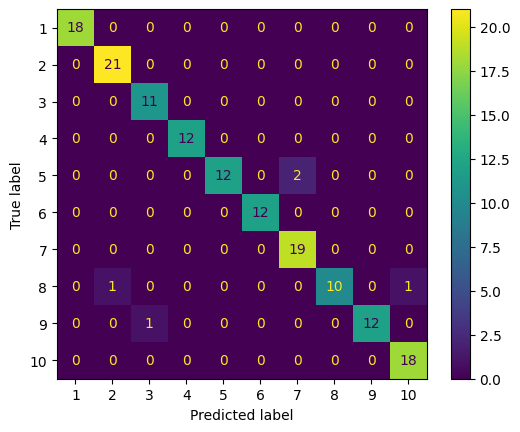

In [25]:
#predecir
y_estimado = opt_ex_tree_gs.predict(X_test_selec)

#mostrar los resultados de la matriz de confusión.
cm = confusion_matrix(y_test, y_estimado)
print(classification_report(y_test, y_estimado))
disp = ConfusionMatrixDisplay(cm, display_labels=('1','2','3', '4','5','6','7','8','9','10'))

disp.plot()
plt.show()

#### 5.5 Visualización de la curva de aprendizaje

Se observa que en el modelo seleccionado la curva de aprendizaje alcanza el máximo score en el conjunto de entrenamiento, esto podría significar sobreajuste, sin embargo, en el proceso de optimización del modelo se ajustaron algunos hiperparámetros que ayudan a evitar esta situación, en específico se limitó la profundidad del árbol.  
Por otra parte, el modelo ExtraTree y ExtraTree optimizado predicen con un 97% de precisión en el set de testeo.  
En el análisis de las curvas de aprendizaje se observa que la optimización no incrementa sustancialmente el F1 score. Por otra parte, aumenta los tiempos de ajuste del modelo para los conjuntos de entrenamiento.  

Se plotean las siguientes curvas de aprendizaje:  
* ExtraTree
* ExtraTree optimizado
* ExtraTree optimizado con 3 features  
* GaussianNB  

Se consideró también la curva de aprendizaje del modelo que quedó en segundo lugar GaussianNB, de este se oberva que el score de entrenamiento es cercano al máximo, sin embargo, disminuye con más muestras. Además la performance del modelo tiene un comportamiento algo extraño.

In [26]:
#Función para graficar la curva de aprendizaje, obtenida de la documentación de sklearn, se modificó el score para que sea f1
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                        scoring=f1_scorer,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

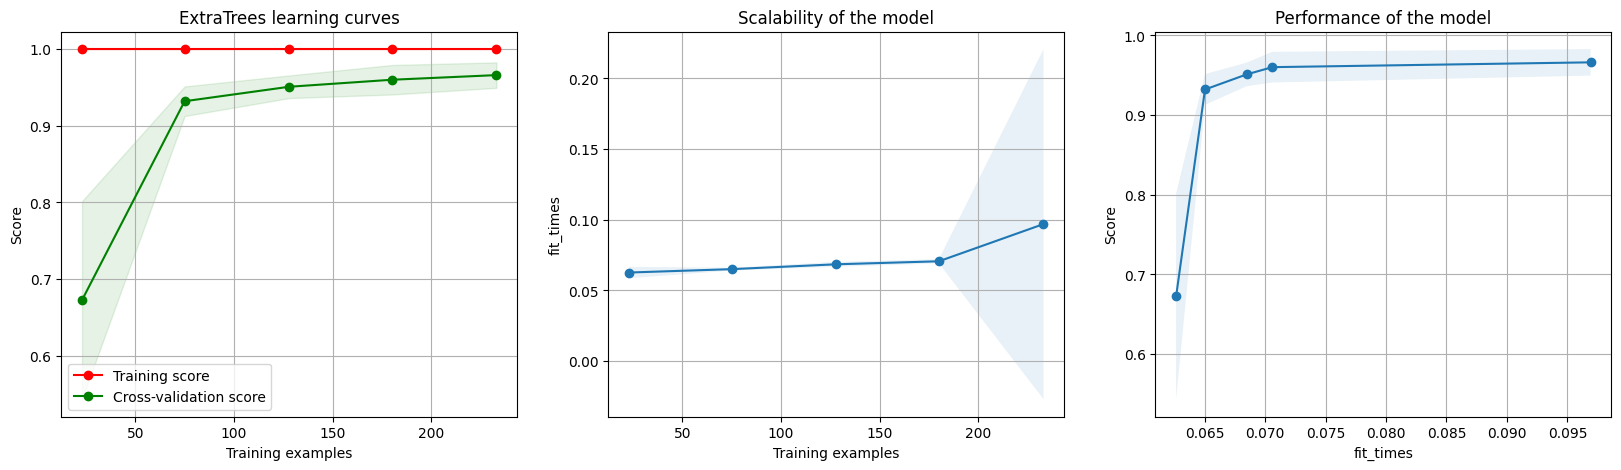

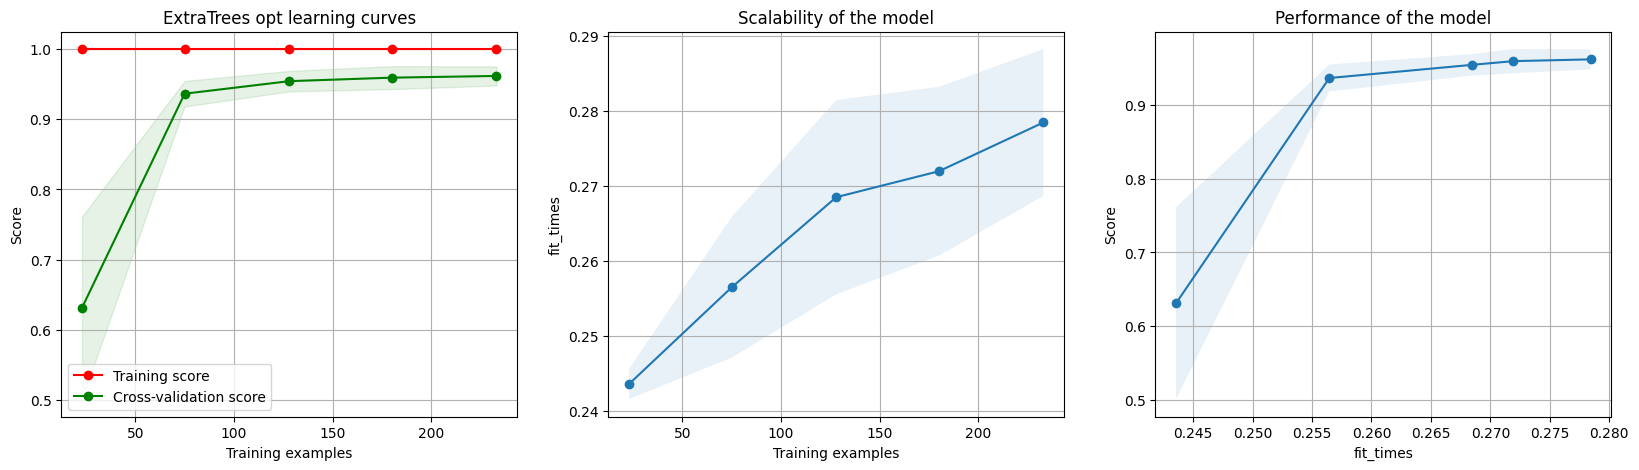

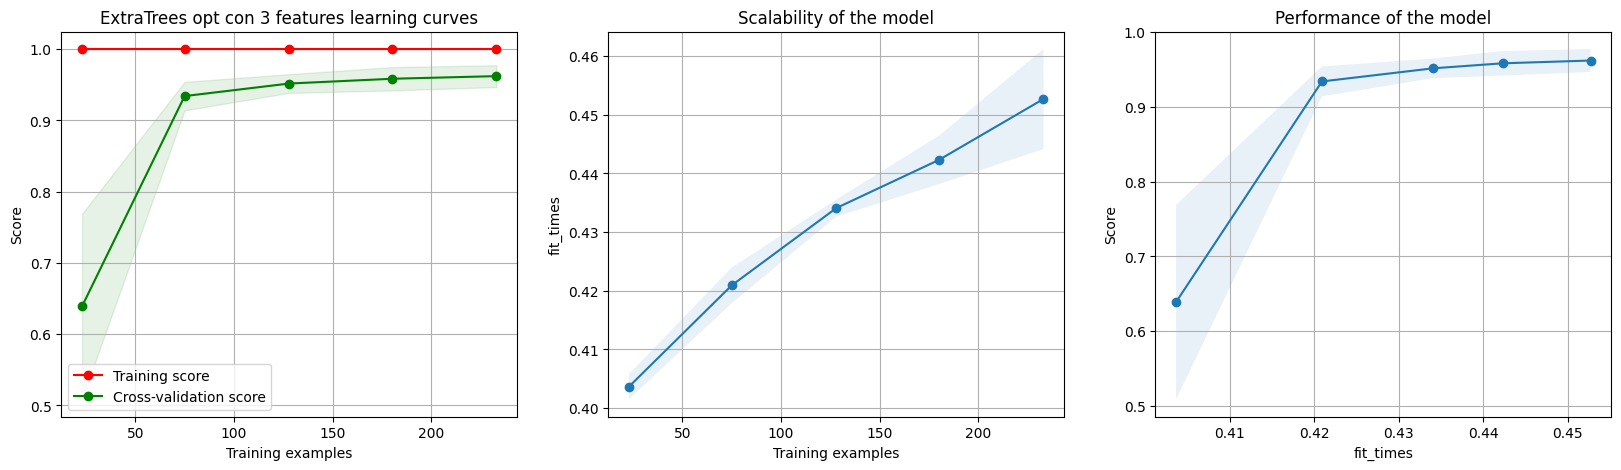

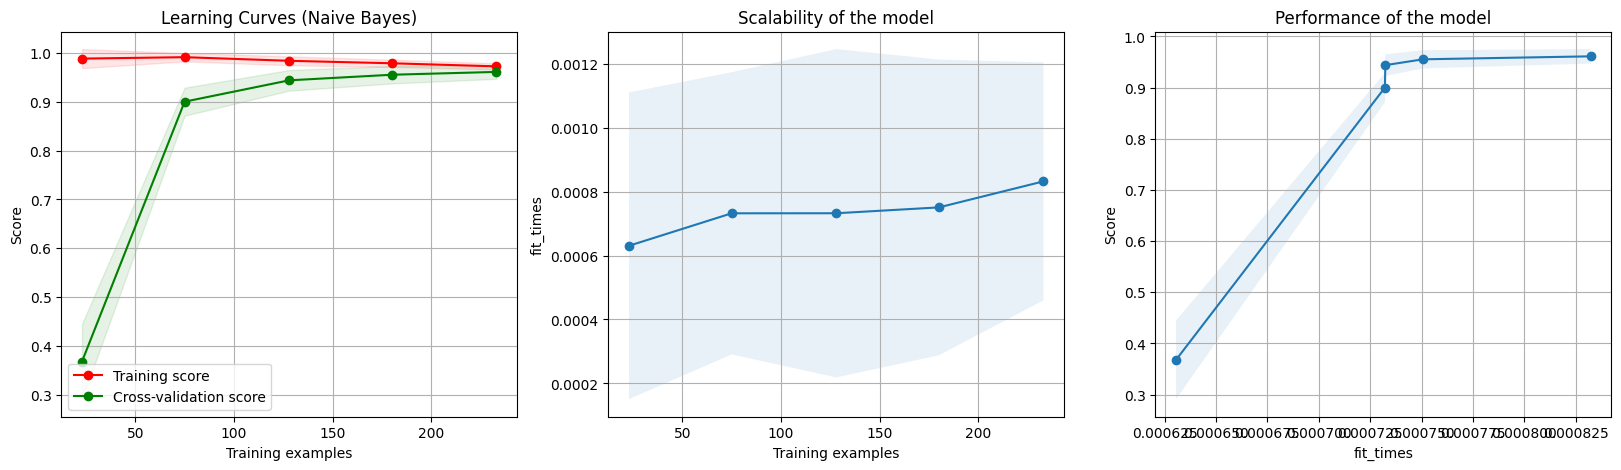

In [27]:
#Ploteo de curvas de aprendizaje
g = plot_learning_curve(ExtraTreesClassifier(),'ExtraTrees learning curves',X_train_selec,y_train,cv=rkf) #ExtraTreesClassifier con parámetros por defecto
g = plot_learning_curve(opt_ex_tree_gs.best_estimator_,'ExtraTrees opt learning curves',X_train_selec,y_train,cv=rkf) #ExtraTreesClassifier con parámetros optimizados
g = plot_learning_curve(opt_ex_tree_gs3f.best_estimator_,'ExtraTrees opt con 3 features learning curves',X_train_selec,y_train,cv=rkf) #ExtraTreesClassifier con parámetros optimizados y 3 features
g = plot_learning_curve(GaussianNB(),'Learning Curves (Naive Bayes)',X_train_selec,y_train,cv=rkf) #Naive Bayes

### 6. Conclusiones

Se utilizó un análisis discriminante lineal (LDA), para encontrar las compoenntes que maximizan la distancia entre clases. Posteriormente se utilizó un modelo de árbol de decisción para encontrar las características de mayor importancia con posterior selección de variables con la técnica SBS, este enfoque permitió mantenener el principio de ganancia de información y reducir el número de variables de 9 a 6.  

De los modelos evaluados, el que presentó mayor score F1 fue ExtraTree con F1 promedio = 0.9631 y DesvEst = 0.016.  
Se utilzaron validaciones cruzadas para dar mayor robustez a los resultados, con 3 splits y 10 repeticiones.  

Se realizó una optimización del modelo, pero esto no mejoró su rendimiento, sin embargo, resulta positivo el hecho de seleccionar y limitar parámetros como la profunidad del árbol (que en este caso quedó en 8) y la cantidad de árboles, ya que esto puede prevenir sobreajustes del modelo. De esta búsqueda exhaustiva de parámetros, el n óptimo de características fue 5.

Además, se realizó un segundo ajuste, **utilizando 3 características**, lo que resultó en un score muy similar y con un idéntico rendimiento predictivo (accuracy de 97%), sin embargo, la escalabilidad del modelo se vió alterada.  

Finalmente, se considera que el óptimo de características para el modelo ExtraTree es 5.

### 4. Referencias  
https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2  
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html  
https://stackoverflow.com/questions/62610782/fishers-linear-discriminant-in-python  
https://towardsdatascience.com/lda-linear-discriminant-analysis-how-to-improve-your-models-with-supervised-dimensionality-52464e73930f  
https://qu4nt.github.io/sklearn-doc-es/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py  
https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling